This notebook presents my solution for this competition. In summary, the process was as follows:
- <b> Split of sections / images for train and validation </b>. For this, in each direction (inline and crossline), the total of sections were divided into 10 groups. From each group, 70% of the first sections were for training and the rest for validation. This to avoid overfitting.
- <b> Creation of patches </b>. These were generated from the sections selected in the split. In order not to lose much information and to be compatible with encoder-decoder networks, 512x512 patches were established. In addition to this, hard data augmentation was applied.
- <b> Training </b>. The network used was a variation of the well-known U-Net. In this proposed version, dilated convolutional layers were used in the bottleneck to keep the context information since the images are relatively large. The stopping criterion was used with respect to the weighted F1-score, where the weight of each class was the inverse of its frequency.
- <b> Inference </b>. Finally, inference was performed in both directions separately, and then an ensembling was applied to give a more stable result.

### Import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.util.shape import view_as_windows
from tqdm import tqdm
import random
import os

from keras.utils import Sequence
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint

# custom functions
from models import AtrousUNet
from metrics import mF1_w
from utils import PlotHistory

from albumentations import (
    HorizontalFlip, VerticalFlip, 
    ShiftScaleRotate, OpticalDistortion, GridDistortion, ElasticTransform, 
    RandomBrightnessContrast, 
    IAASharpen, IAAEmboss, Flip, OneOf, Compose, RandomSizedCrop, IAAAffine   
)

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# 1. Split

For the split, the process shown in the image below was followed, where in this case it is being carried out along the crossline direction. As can be seen, they are divided into groups (10 in our case), where 70% of the first images go to train, and the rest to validation. The same is done in the inline direction.

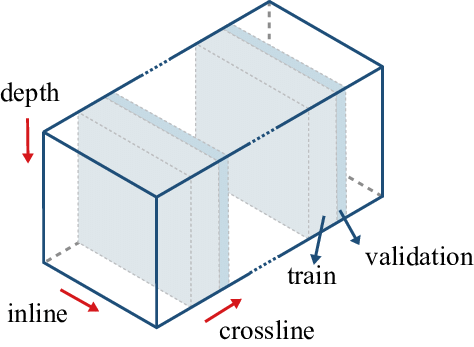

In [3]:
# paths:
root = 'seismic-facies-identification-challenge/'
save_folder = 'patches1'

# scale factor
min_ = -5184.1055
max_ = 5151.7188

# patch size
ps = 512
step = 100

In [4]:
# loading data
X = np.load('{}/data_train.npz'.format(root))['data']
y = np.load('{}/labels_train.npz'.format(root))['labels']
y.shape # Z, X, Y

(1006, 782, 590)

### Generate splits texts:

In [5]:
def split_train_val(iline, xline, loader_type='section', n_groups=10, per_val=0.3):
    """
    Create txt files to split inline and crossline 2D sections in training and validation 
    """
    
    vert_locations = range(0, iline-n_groups, n_groups)
    horz_locations = range(0, xline-n_groups, n_groups)
    
    p_tr_list = []
    p_vl_list = []
    for i in vert_locations:
        vert_slides = np.arange(i, i+n_groups)
        
        aux = list(vert_slides[:-int(per_val*n_groups)])
        p_tr_list += ['i_' + str(ii) for ii in aux if ii < iline]
        
        aux = list(vert_slides[-int(per_val*n_groups):])
        p_vl_list += ['i_' + str(ii) for ii in aux if ii < iline]
    
    random.shuffle(p_tr_list)
    random.shuffle(p_vl_list)
    
    aux1 = []
    aux2 = []
    for j in horz_locations:
        horz_slides = np.arange(j, j+n_groups)
        
        aux = list(horz_slides[:-int(per_val*n_groups)])
        aux1 += ['x_' + str(jj) for jj in aux if jj < xline]
        
        aux = list(horz_slides[-int(per_val*n_groups):])
        aux2 += ['x_' + str(jj) for jj in aux if jj < xline]

    random.shuffle(aux1)
    random.shuffle(aux2)
    
    p_tr_list+=aux1
    p_vl_list+=aux2
    
    path_splits = '{}/splits'.format(root)
    
    if not os.path.exists(path_splits):
        os.makedirs(path_splits)
    
    file_object = open(os.path.join(path_splits, loader_type + '_train.txt'), 'w')
    file_object.write('\n'.join(p_tr_list))
    file_object.close()
    
    file_object = open(os.path.join(path_splits, loader_type + '_val.txt'), 'w')
    file_object.write('\n'.join(p_vl_list))
    file_object.close()

In [5]:
_, iline, xline = y.shape
split_train_val(iline, xline, loader_type='section2', per_val=0.3)

# 2.  Patches Generation

Although there are scientific articles that demonstrate the superiority of using slices over 2D patches in volumes of data, in this case, the slices are relatively large with respect to the classes with less presence. That is why 512x512 patches were generated in this process to avoid losing context information. All of them are saved as *.npy* file.

In [6]:
# scaling
X = (X - min_)/(max_ - min_)

# padding:
X = np.pad(X,((0,6),(0,30), (0,22)), "reflect")
y = np.pad(y,((0,6),(0,30), (0,22)), "reflect")
y.shape

(1012, 812, 612)

In [8]:
def makePatches(split='train'):
    """
    Save each patch as .npy file 
    """
    
    os.makedirs("{}/{}/input".format(save_folder, split))
    os.makedirs("{}/{}/label".format(save_folder, split))

    path = os.path.join(root, 'splits', 'section2_' + split + '.txt')
    patch_list = tuple(open(path, 'r'))

    data = {}
    data['i'] = []
    data['x'] = []

    for indexes in patch_list:
        direction, number = indexes.split(sep='_')
        if direction == 'i':
            data['i'].append(int(number))
        elif direction == 'x':
            data['x'].append(int(number))
            
    X_train = []
    y_train = []
    
    # direction i
    subX = X[:, data['i'], :]
    suby = y[:, data['i'], :]

    for i in tqdm(range(suby.shape[1])):
        img  = subX[:,i]
        mask = suby[:,i]

        img = np.pad(img, ((0,6),(0,22)),"reflect")

        splitsX = view_as_windows(img, (ps, ps), step=step)
        splitsy = view_as_windows(mask, (ps, ps), step=step)

        ni, nj, _, _ = splitsy.shape

        X_train.append(np.reshape(splitsX, (ni*nj, ps, ps)))
        y_train.append(np.reshape(splitsy, (ni*nj, ps, ps)))
        
    # direction x
    subX = X[:, :, data['x']]
    suby = y[:, :, data['x']]

    for i in tqdm(range(suby.shape[2])):
        img  = subX[:,:,i]
        mask = suby[:,:,i]

        splitsX = view_as_windows(img, (ps, ps), step=step)
        splitsy = view_as_windows(mask, (ps, ps), step=step)

        ni, nj, _, _ = splitsy.shape

        X_train.append(np.reshape(splitsX, (ni*nj, ps, ps)))
        y_train.append(np.reshape(splitsy, (ni*nj, ps, ps)))
        
    X_train = np.vstack(X_train)
    y_train = np.vstack(y_train)
    
    # saving
    for i in tqdm(range(len(X_train))):
        np.save('{}/{}/input/{}.npy'.format(save_folder, split, i), X_train[i])
        np.save('{}/{}/label/{}.npy'.format(save_folder, split, i), y_train[i])

In [9]:
makePatches(split='train')
makePatches(split='val')

  0%|          | 0/546 [00:00<?, ?it/s]/usr/local/lib/python3.5/dist-packages/skimage/util/shape.py:246: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "
100%|██████████| 6984/6984 [00:30<00:00, 230.63it/s]


In [10]:
# clean memory
del X, y

# 3. Training

The neural network used is a modified version of U-Net with its main difference being the bottleneck. For more details, see its [implementation in Keras](https://github.com/lyakaap/Kaggle-Carvana-3rd-place-solution). For loss, the categorical cross-entropy loss seems to give good results.

In [11]:
idd=10
model_name = "atrous_unet"
f1 = 16
type_aug = "aug10"

bs = 32
_epochs = 100
lossf = 'categorical_crossentropy'

### Generator
Since a large number of patches were generated, it was decided to use a generator to avoid filling the memory. Data augmentation was implemented within the generator.

In [12]:
def one_hot(y):
    """Convert images to one-hot format."""
    return np.eye(6)[y]

In [13]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, split='train', batch_size=32, shuffle=True, aug='all'):

        self.split = split
        self.batch_size = batch_size
        self.aug = aug
        self.shuffle = shuffle
        
        x = os.listdir('{}/{}/input/'.format(save_folder, split))
        self.list_IDs = [i for i in range(len(x))]
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, 512, 512, 1))
        y = np.empty((self.batch_size, 512, 512, 6), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            
            xx = np.load('patches_v2/{}/input/{}.npy'.format(self.split, ID))
            yy = np.load('patches_v2/{}/label/{}.npy'.format(self.split, ID)).astype(int) - 1
            yy = one_hot(yy)
            
            if self.aug:
                X_aug, y_aug = self.augmentation(xx, yy)
            
            # Store sample
            X[i,:,:,0] = X_aug 

            # Store class
            y[i,] = y_aug 

        return X, y
    
    def augmentation(self, X, y):
            
        if self.aug == type_aug:
            aug = OneOf([
                ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=1),
                IAASharpen(p=1),
                IAAEmboss(p=1),
                RandomBrightnessContrast(p=1),
                Compose([VerticalFlip(p=0.5), HorizontalFlip(p=0.5)]),
                RandomSizedCrop(p=1, min_max_height=[384, 500], height=512, width=512),
                IAAAffine(p=1, translate_percent=0.3),
                ElasticTransform(p=1, alpha=400, sigma=400 * 0.05, alpha_affine=400 * 0.03),
                GridDistortion(p=1),
                OpticalDistortion(p=1)
            ], p=0.91)
            
        augmented = aug(image=X, mask=y)
        return augmented['image'], augmented['mask']

In [16]:
train_gen = DataGenerator('train', batch_size=bs, aug=type_aug)
val_gen = DataGenerator('val', batch_size=bs, shuffle=False)

### Modeling

In [17]:
model = AtrousUNet(n_classes=6, filters=f1, n_block=4, BN=True)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
conv2d_70 (Conv2D)              (None, None, None, 1 160         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_49 (BatchNo (None, None, None, 1 64          conv2d_70[0][0]                  
__________________________________________________________________________________________________
activation_49 (Activation)      (None, None, None, 1 0           batch_normalization_49[0][0]     
__________________________________________________________________________________________________
conv2d_71 

In [18]:
lr = 1e-3

opt = Adam(lr=lr, amsgrad=False)

model.compile(optimizer=opt,
              loss = lossf,
              metrics=['acc', mF1_w])

### Train Model

In [19]:
path_res = '/scratch/parceirosbr/maykol.trinidad/Seismic_Challenge/res'
name_weight = '{}_{}_{}_f{}_tmp.hdf5'.format(model_name, idd, type_aug, f1)
filepath = os.path.join(path_res, name_weight)
stopPatience = 10

In [20]:
modelCheck = ModelCheckpoint(filepath,verbose=1, save_best_only=True, save_weights_only=True, period=1, monitor="val_mF1_w", mode='max')
earlystopper = EarlyStopping(patience=stopPatience, verbose=1, monitor="val_mF1_w", mode='max')
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=stopPatience//2, min_lr=0.0000005, verbose=1, monitor="val_mF1_w", mode='max')
cb = [earlystopper,reduce_lr,modelCheck]

In [ ]:
hs = model.fit_generator(train_gen, epochs=_epochs,
                    steps_per_epoch=len(train_gen),
                    callbacks=cb,
                    validation_data=val_gen, validation_steps=len(val_gen),
                    verbose=1, workers=0)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/10
177/509 [=========>....................] - ETA: 23:15 - loss: 1.0351 - acc: 0.6384 - mF1_w: 0.1113

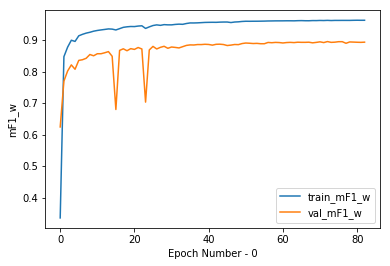

In [27]:
PlotHistory(hs, 'mF1_w')

In [29]:
max(hs.history["val_mF1_w"])

0.8949835784794598

# 4. Inference

As the model was trained using patches in both directions, it was decided to also infer in each direction and then perform an ensembling. Since many images are overlaid, it was also created a *count* matrix that counts the number of times a pixel has been overlaid. In this way, when dividing the cumulative prediction matrix over the *count* matrix, the range was kept between 0 and 1.

In [31]:
# load the best model
model.load_weights(filepath)

In [33]:
step = 100

### X axis

In [32]:
test2 = np.load(os.path.join(root, 'data_test_2.npz' ))['data']
test2.shape

(1006, 334, 841)

In [ ]:
#padding
test2_pad = np.pad(test2,((0,6),(0,0), (0,71)),"reflect")
test2_pad.shape

In [35]:
# scaling
test2_pad = (test2_pad - min_)/(max_ - min_)

In [36]:
pred_pad   = np.zeros(test2_pad.shape + (6,))
counts_pad = np.zeros(test2_pad.shape + (6,))

for iin in tqdm(range(test2.shape[1])):
    
    section = test2_pad[:,iin]
    splits = view_as_windows(section, (ps, ps), step=step)
    ni, nj, _, _ = splits.shape
    
    ii = 0
    for i in range(ni):
        jj = 0
        for j in range(nj):
            split_ij = np.expand_dims(splits[i,j], axis=[0,-1])
            pred_pad[ii:(ii+ps) ,iin, jj:(jj+ps),:] += model.predict(split_ij)[0]
            counts_pad[ii:(ii+ps) ,iin, jj:(jj+ps),:] += np.ones((ps,ps,6))
            jj+=step
        ii+=step

  0%|          | 0/334 [00:00<?, ?it/s]/usr/local/lib/python3.5/dist-packages/skimage/util/shape.py:246: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "
100%|██████████| 334/334 [04:35<00:00,  1.21it/s]


In [37]:
# normalize results
pred_pad_in = pred_pad/counts_pad

### Y axis

In [38]:
data = np.concatenate([
    np.concatenate([
        np.load('{}/data_train.npz'.format(root))['data'], 
        np.load('{}/data_test_1.npz'.format(root))['data']
    ], axis=2), 
    test2
], axis=1)
data.shape

(1006, 1116, 841)

In [39]:
data = data[:,604:]
data.shape

(1006, 512, 841)

In [40]:
test22_pad = np.pad(data,((0,6),(0,0), (0,0)),"reflect")
test22_pad.shape

(1012, 512, 841)

In [41]:
del data, counts_pad

In [42]:
# scaling
test22_pad = (test22_pad - min_)/(max_ - min_)

In [43]:
pred_pad2   = np.zeros(test22_pad.shape + (6,))
counts_pad2 = np.zeros(test22_pad.shape + (6,))

for xn in tqdm(range(test2.shape[2])):
    
    section = test22_pad[:,:,xn]
    splits = view_as_windows(section, (ps, ps), step=step)
    ni, nj, _, _ = splits.shape
    
    ii = 0
    for i in range(ni):
        jj = 0
        for j in range(nj):
            split_ij = np.expand_dims(splits[i,j], axis=[0,-1])
            pred_pad2[ii:(ii+ps) , jj:(jj+ps), xn , :] += model.predict(split_ij)[0]
            counts_pad2[ii:(ii+ps) , jj:(jj+ps), xn , :] += np.ones((ps,ps,6))
            jj+=step
        ii+=step

100%|██████████| 841/841 [03:44<00:00,  3.74it/s]


In [44]:
pred_pad_xs = pred_pad2/counts_pad2

### Ensembling

Finally it was tested with different weight values for each predicted cube in each direction. As the one performed on the *x* axis showed better results visually than the *y* axis, it was given greater weight. However, both helped an optimal solution.

In [46]:
pred_pad_in_lab = np.argmax(pred_pad_in[:1006,:,:841],-1)
pred_pad_xs_lab = np.argmax(pred_pad_xs[:1006,-334:,:841],-1)

In [47]:
# this parameter is the weight for the inference on both directions (x and y):
w1 = 0.6 
pred_final_tmp = np.argmax(pred_pad_in[:1006,:,:841] * w1  + pred_pad_xs[:1006,-334:] * (1.-w1), axis=-1)

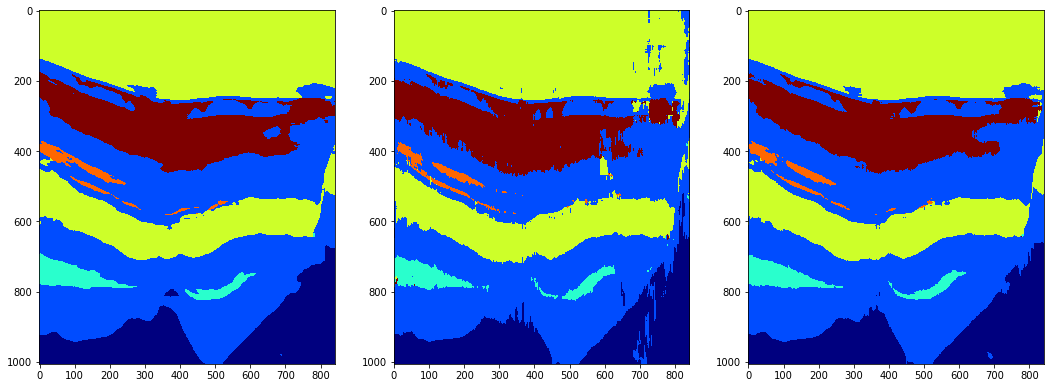

In [48]:
# Y-Z
fig, axes = plt.subplots(1,3, figsize=[18,7])

xline=80
axes[0].imshow(pred_pad_in_lab[:, xline], cmap="jet")
axes[1].imshow(pred_pad_xs_lab[:, xline], cmap="jet")
axes[2].imshow(pred_final_tmp[:, xline], cmap="jet")

In [50]:
labels_pred_w = pred_final_tmp + 1
np.unique(labels_pred_w)

array([1, 2, 3, 4, 5, 6])

In [51]:
# submission
# np.savez_compressed("subs/sub10_w", prediction=labels_pred_w)